In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/usr/bin/python


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = params.ticker
folder = "Intraday stocks" 

month_to_plot = '2024-05' # just used if date_to_check = None

date_to_check = params.date_to_check 

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


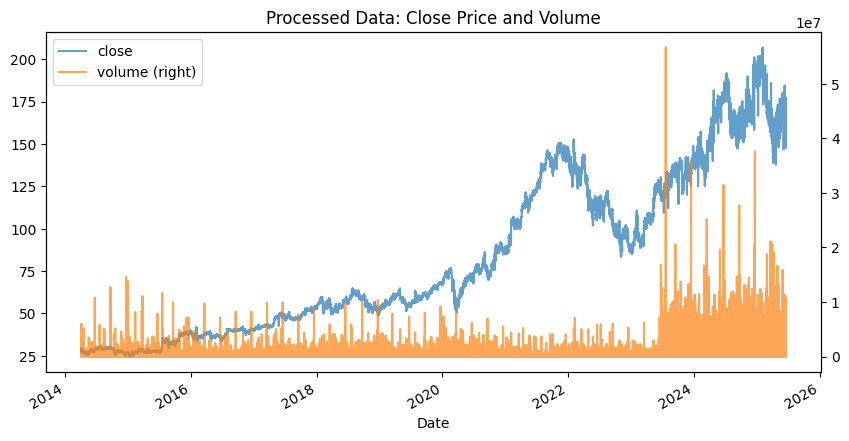

open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = trades.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=params.bidasktoclose_spread,
                                vol_fact=1)

df

In [4]:
def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    try:
        day_df_prep = trades.prepare_interpolate_data( 
            df=day_df,
            regular_start_shifted=params.regular_start_shifted,
            regular_start=params.regular_start,
            regular_end=params.regular_end
        )
    except ValueError as ve:
        if "window 0" in str(ve):
            print(" warning: smoothing window=0; skipping smoothing.")
        else:
            raise

    result = trades.run_trading_pipeline(day_df_prep, 
                                         col_signal='signal_smooth',
                                         col_action='signal_action',
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal_raw',
        col_signal2='signal_smooth',
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [5]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_raw", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for d in sorted(days.astype(str)):
                res = process_single_day(d, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            monthly_summary = plots.aggregate_performance(performance_list, df_month)
            pprint(monthly_summary)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode")
        
    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(
        df=df,
        regular_start_shifted=params.regular_start_shifted,
        regular_start=params.regular_start,
        regular_end=params.regular_end
    )
      
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df_prep,
        col_signal='signal_smooth',
        col_action='signal_action',
        day_to_check=None
    )

    print("\n Step C: merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    all_summary = plots.aggregate_performance(performance_all, df_all)
    days_all = df_all.index.normalize().unique()
    pprint(all_summary)

    # prepare the performances summary just for the test days
    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    test_summary = plots.aggregate_performance(performance_test, df_test)
    pprint(test_summary)
    

    print("\n Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_ready.csv"
    df_all.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return df_all



Month mode: processing 2021-04

=== Processing trading day 2021-04-01 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


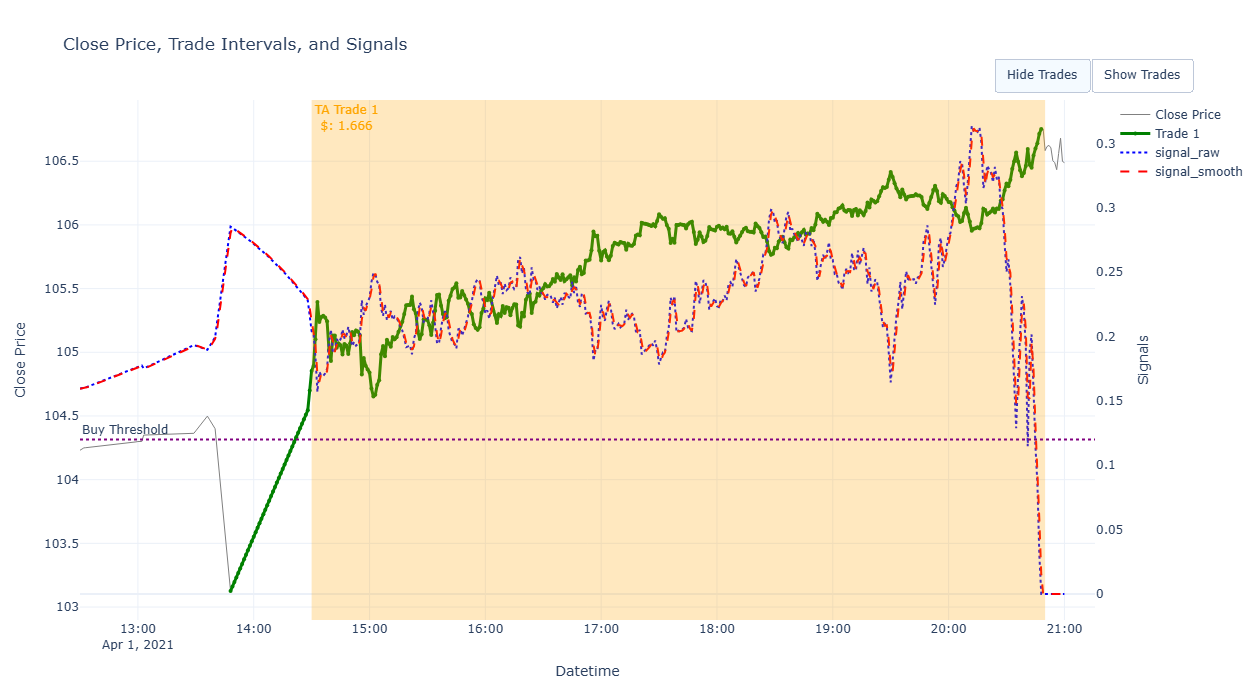


=== Performance for 2021-04-01 00:00:00 ===
Strategy Return ($): 1.666
Buy & Hold Return ($): 1.582
Trades Returns ($): [1.666]

=== Processing trading day 2021-04-05 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


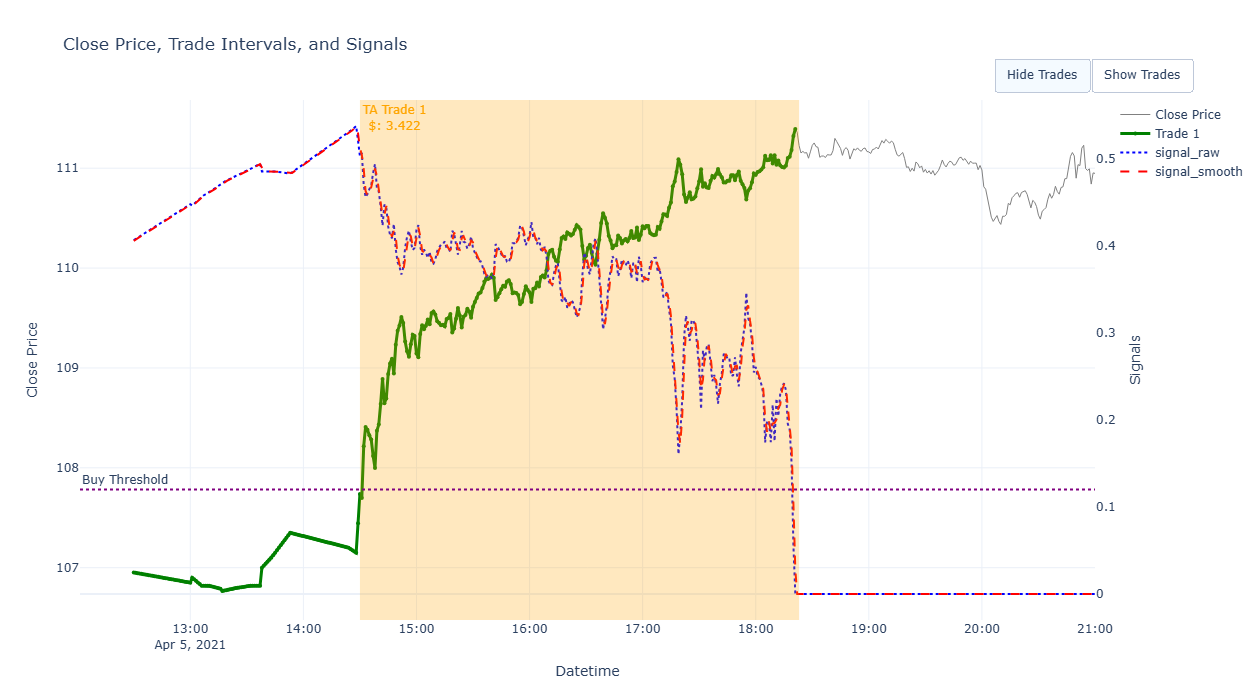


=== Performance for 2021-04-05 00:00:00 ===
Strategy Return ($): 3.422
Buy & Hold Return ($): 3.149
Trades Returns ($): [3.422]

=== Processing trading day 2021-04-06 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


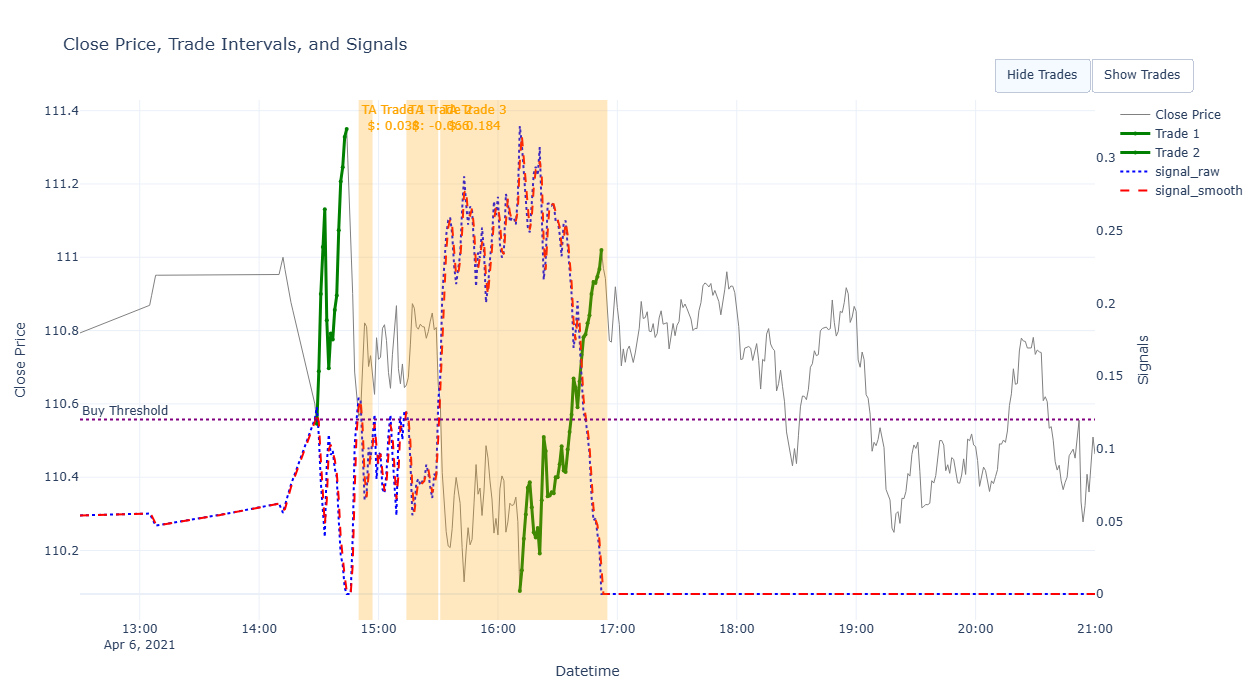


=== Performance for 2021-04-06 00:00:00 ===
Strategy Return ($): 0.155
Buy & Hold Return ($): -0.246
Trades Returns ($): [0.038, -0.066, 0.184]

=== Processing trading day 2021-04-07 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


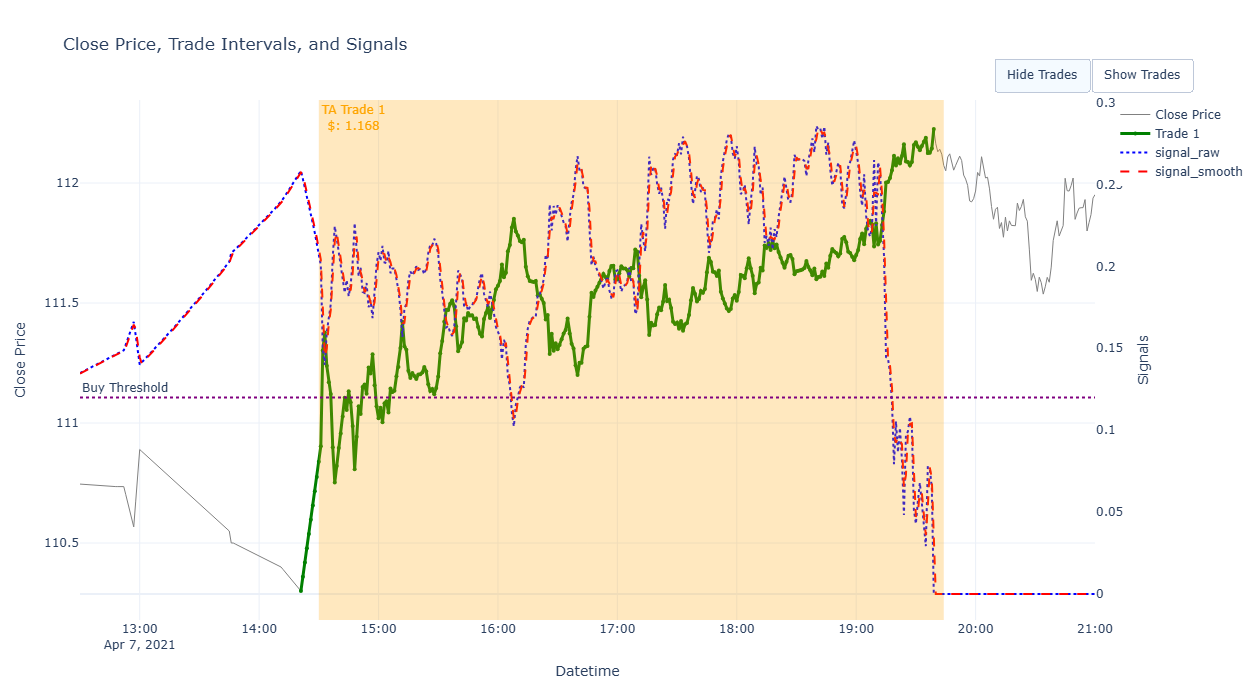


=== Performance for 2021-04-07 00:00:00 ===
Strategy Return ($): 1.168
Buy & Hold Return ($): 1.032
Trades Returns ($): [1.168]

=== Processing trading day 2021-04-08 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


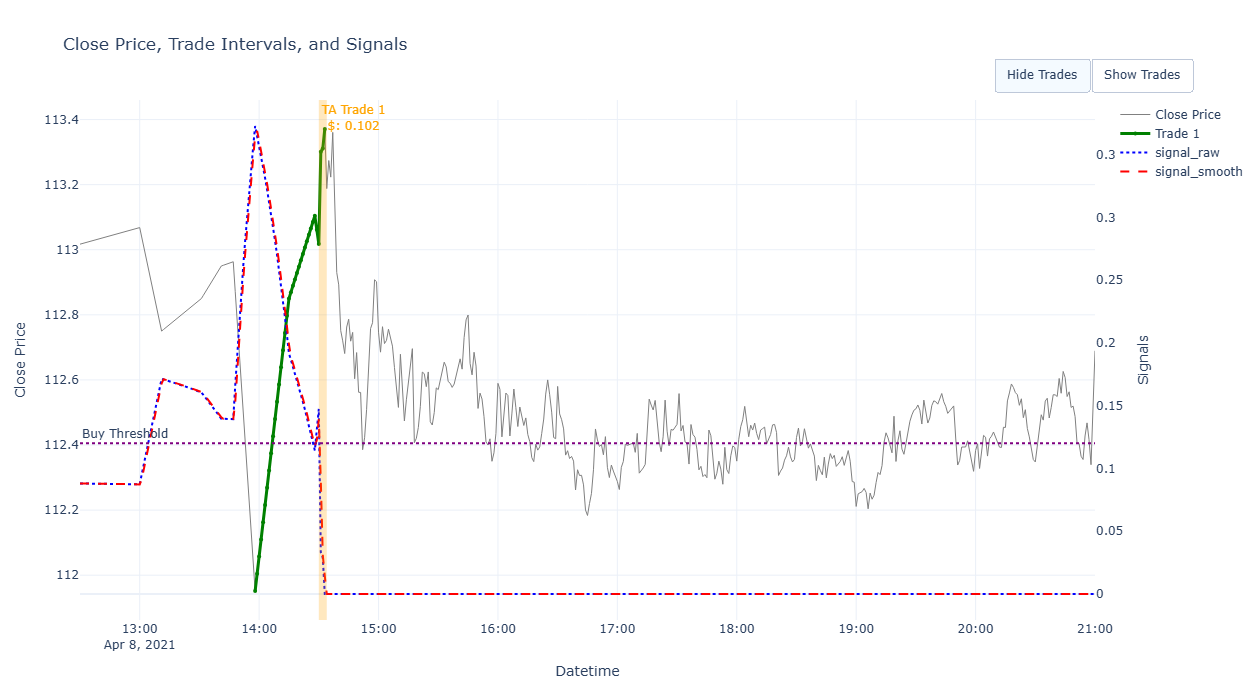


=== Performance for 2021-04-08 00:00:00 ===
Strategy Return ($): 0.102
Buy & Hold Return ($): -0.554
Trades Returns ($): [0.102]

=== Processing trading day 2021-04-09 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


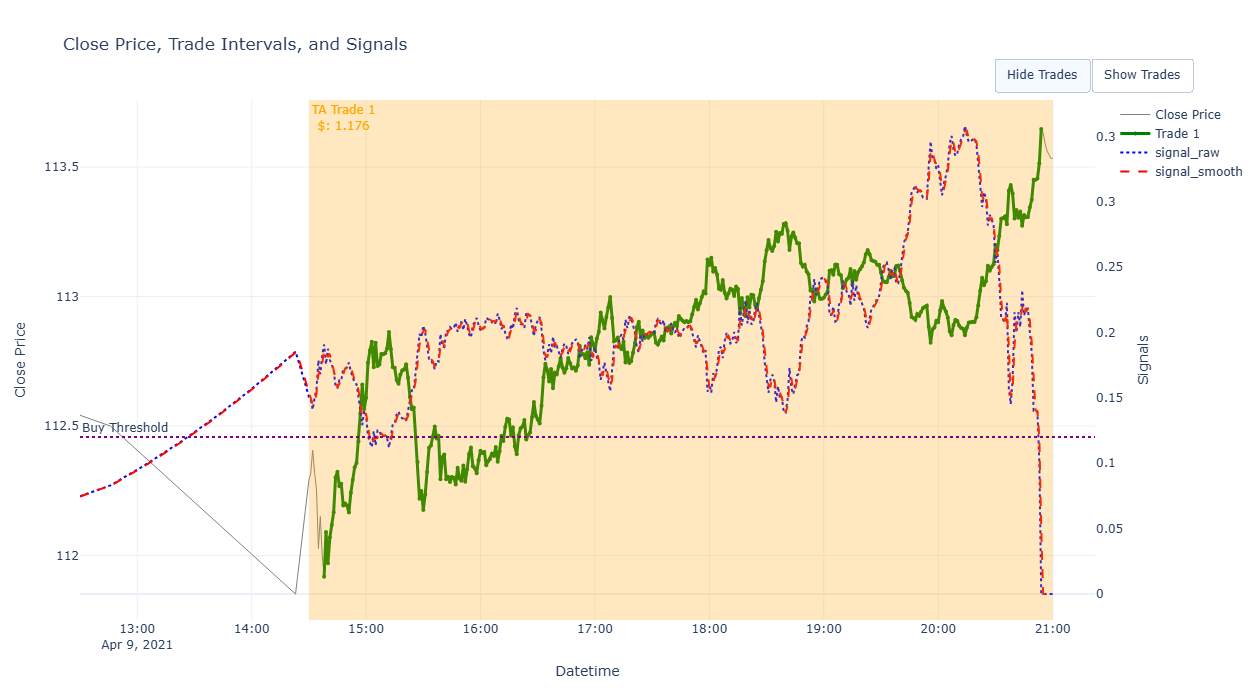


=== Performance for 2021-04-09 00:00:00 ===
Strategy Return ($): 1.176
Buy & Hold Return ($): 1.176
Trades Returns ($): [1.176]

=== Processing trading day 2021-04-12 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


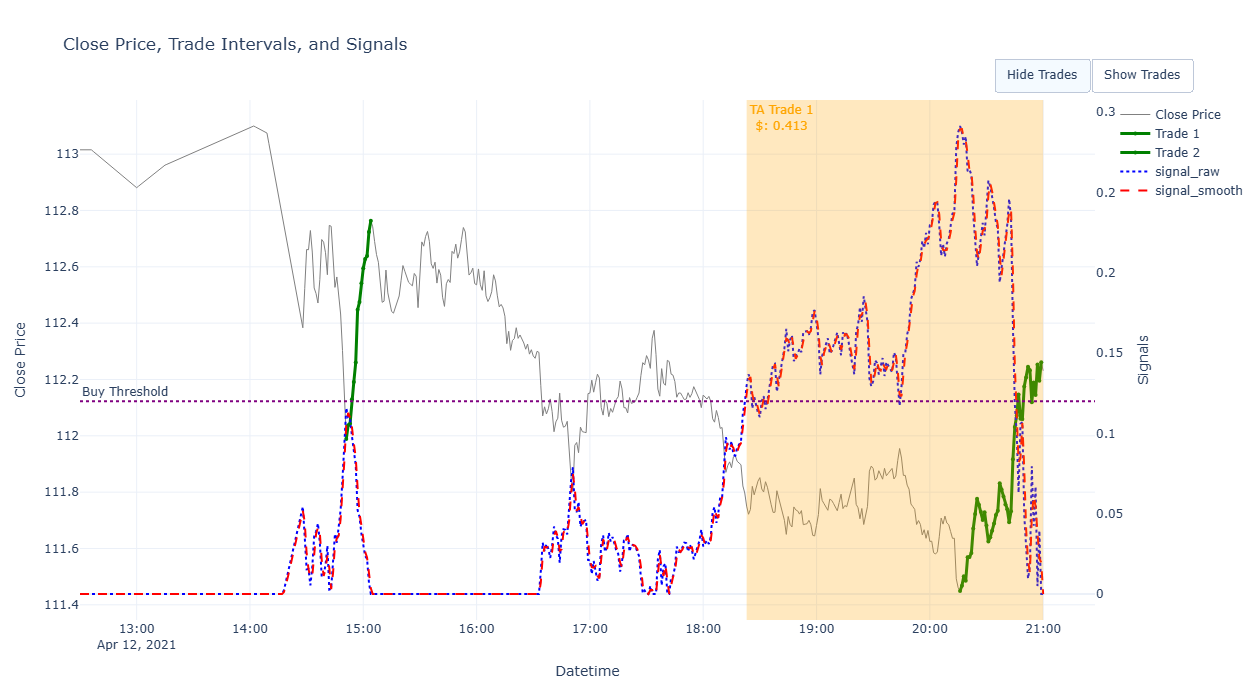


=== Performance for 2021-04-12 00:00:00 ===
Strategy Return ($): 0.444
Buy & Hold Return ($): -0.467
Trades Returns ($): [0.413]

=== Processing trading day 2021-04-13 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


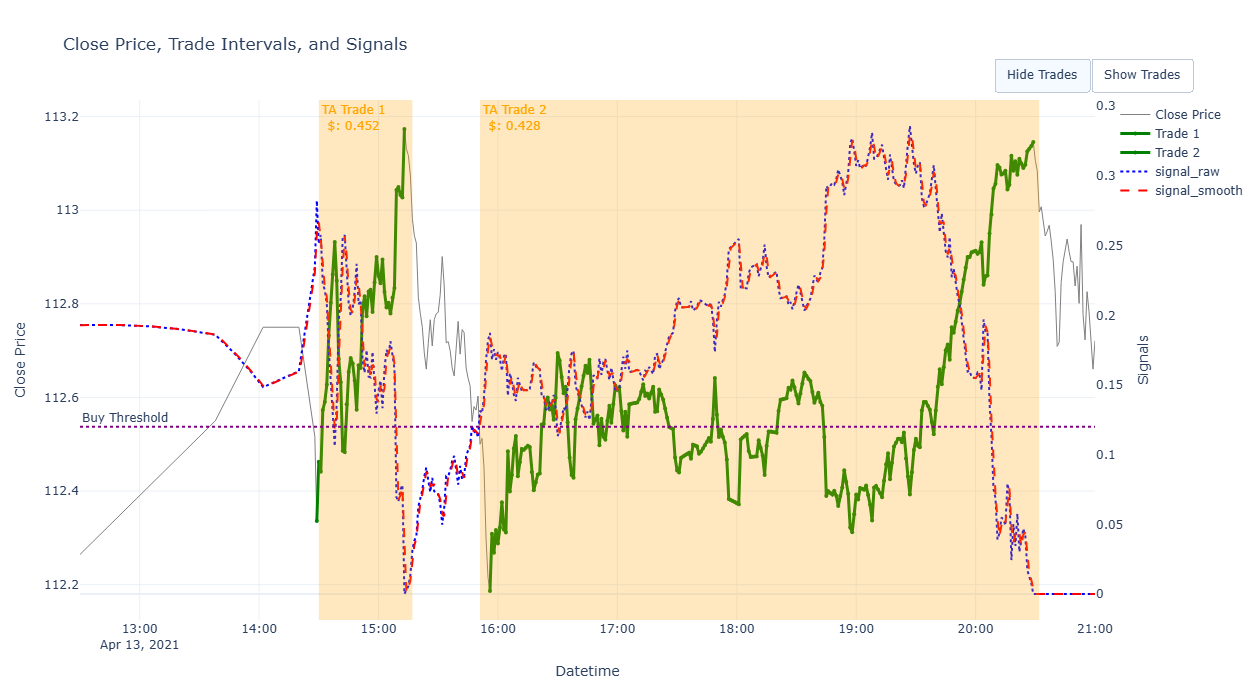


=== Performance for 2021-04-13 00:00:00 ===
Strategy Return ($): 0.88
Buy & Hold Return ($): 0.13
Trades Returns ($): [0.452, 0.428]

=== Processing trading day 2021-04-14 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2021-04-15 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



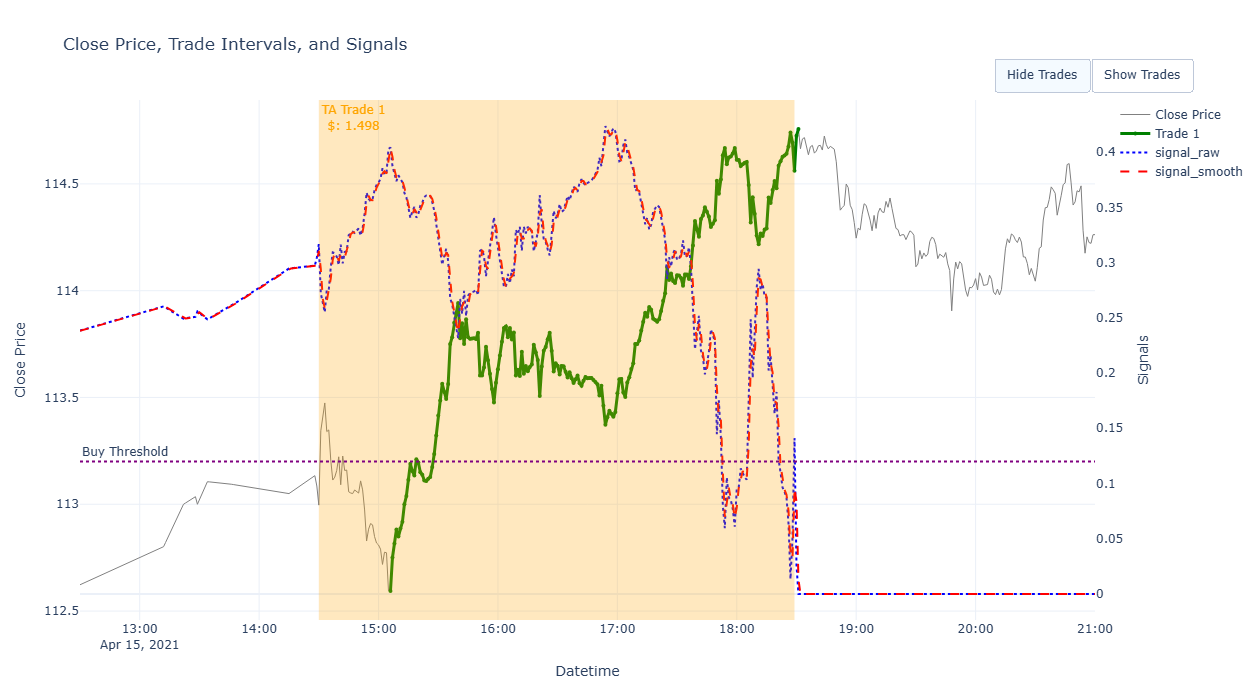


=== Performance for 2021-04-15 00:00:00 ===
Strategy Return ($): 1.498
Buy & Hold Return ($): 1.198
Trades Returns ($): [1.498]

=== Processing trading day 2021-04-16 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


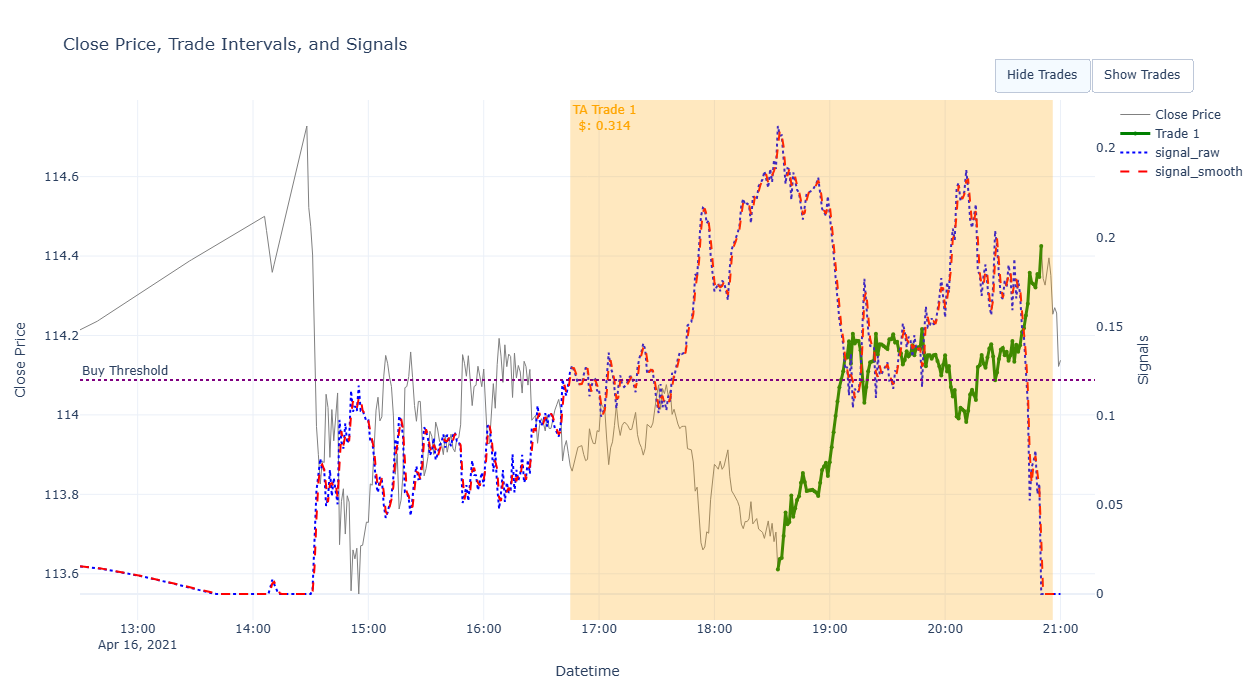


=== Performance for 2021-04-16 00:00:00 ===
Strategy Return ($): 0.314
Buy & Hold Return ($): -0.422
Trades Returns ($): [0.314]

=== Processing trading day 2021-04-19 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


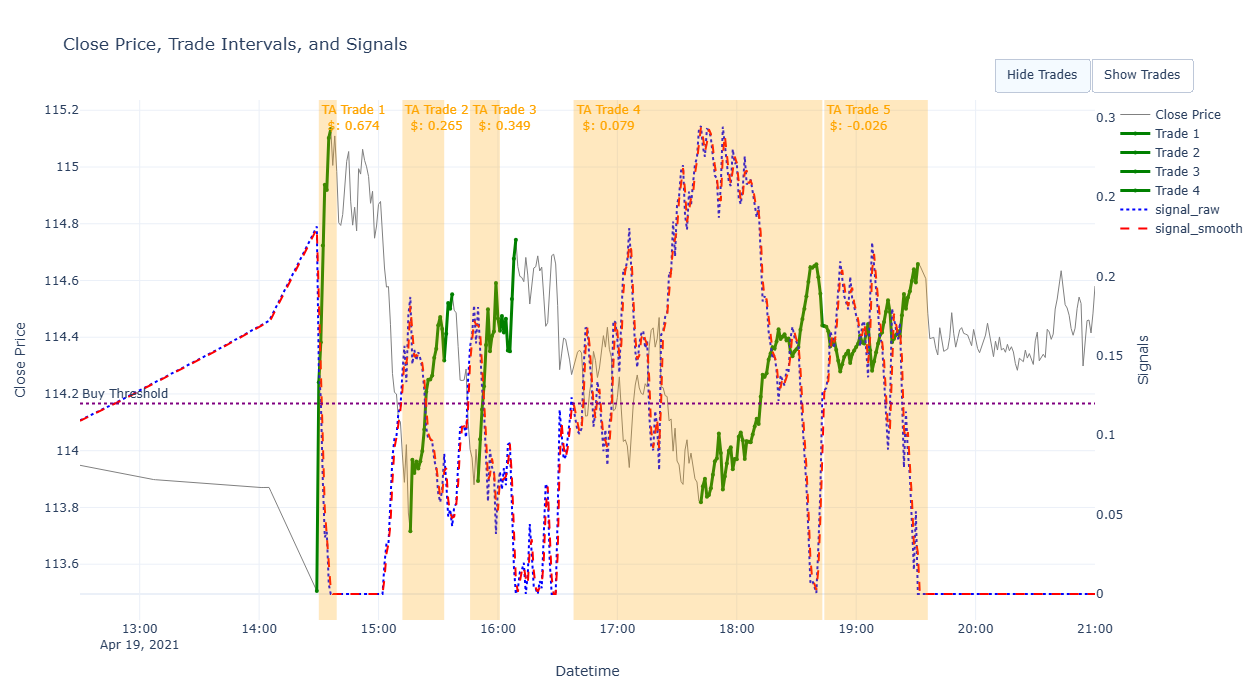


=== Performance for 2021-04-19 00:00:00 ===
Strategy Return ($): 1.341
Buy & Hold Return ($): 0.175
Trades Returns ($): [0.674, 0.265, 0.349, 0.079, -0.026]

=== Processing trading day 2021-04-20 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


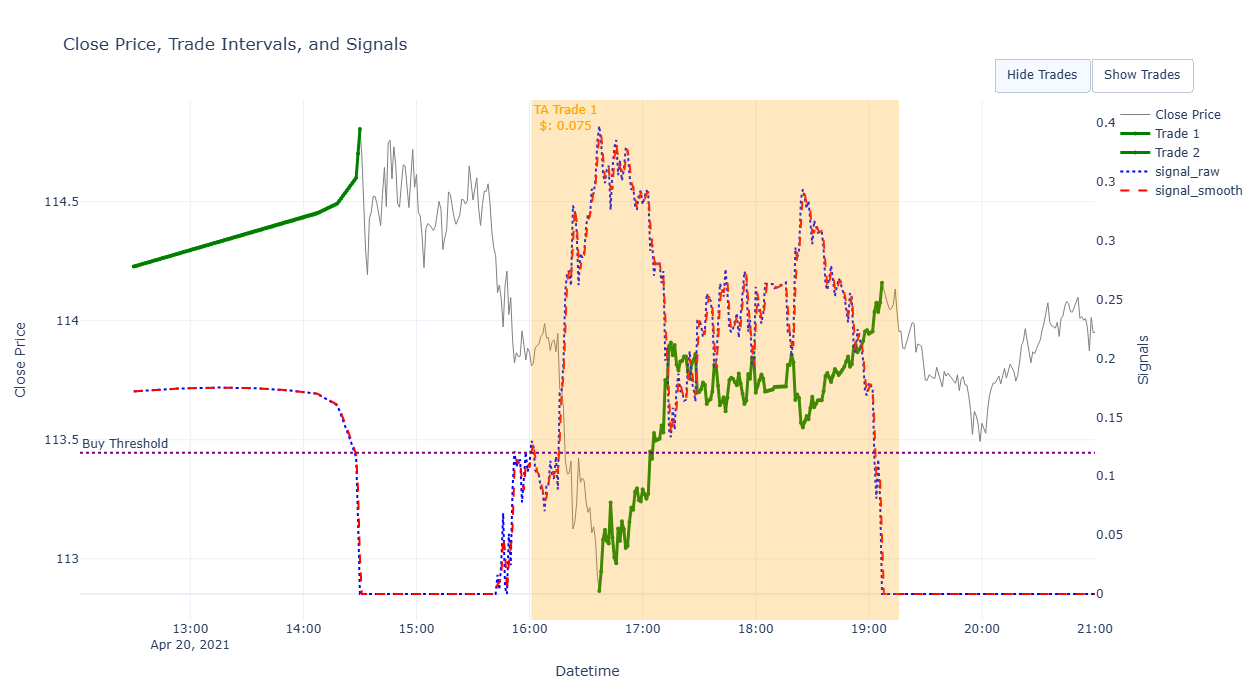


=== Performance for 2021-04-20 00:00:00 ===
Strategy Return ($): 0.075
Buy & Hold Return ($): -0.923
Trades Returns ($): [0.075]

=== Processing trading day 2021-04-21 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


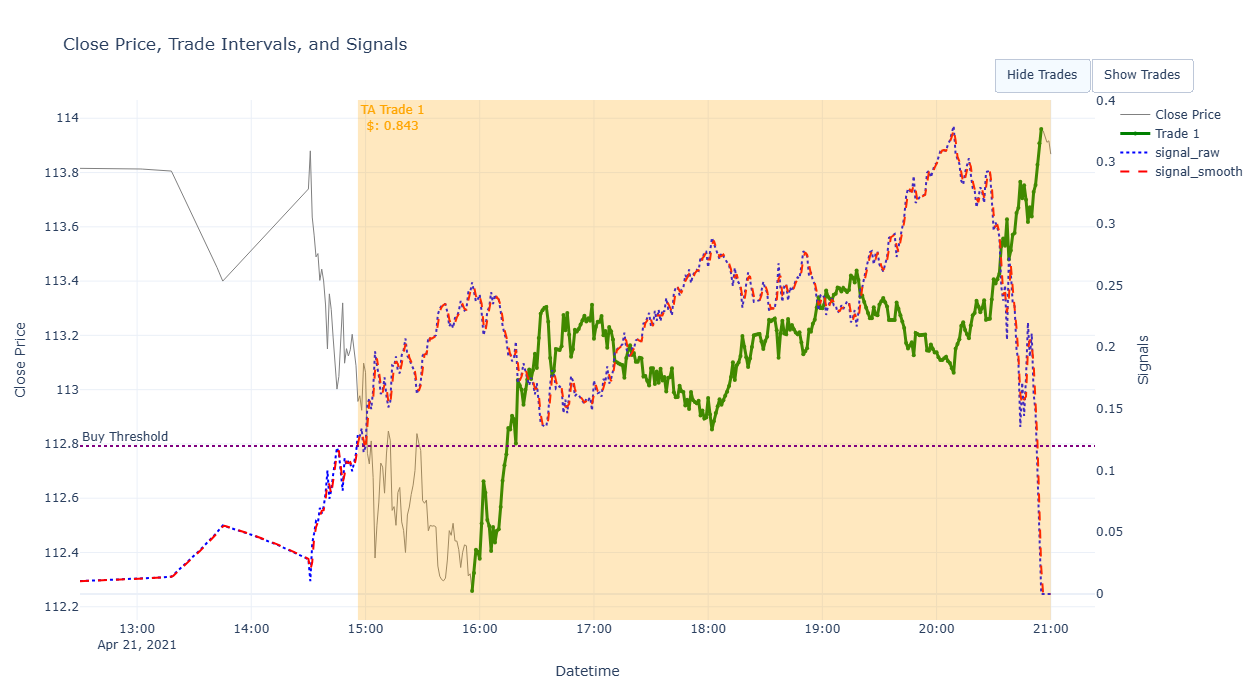


=== Performance for 2021-04-21 00:00:00 ===
Strategy Return ($): 0.892
Buy & Hold Return ($): 0.109
Trades Returns ($): [0.843]

=== Processing trading day 2021-04-22 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


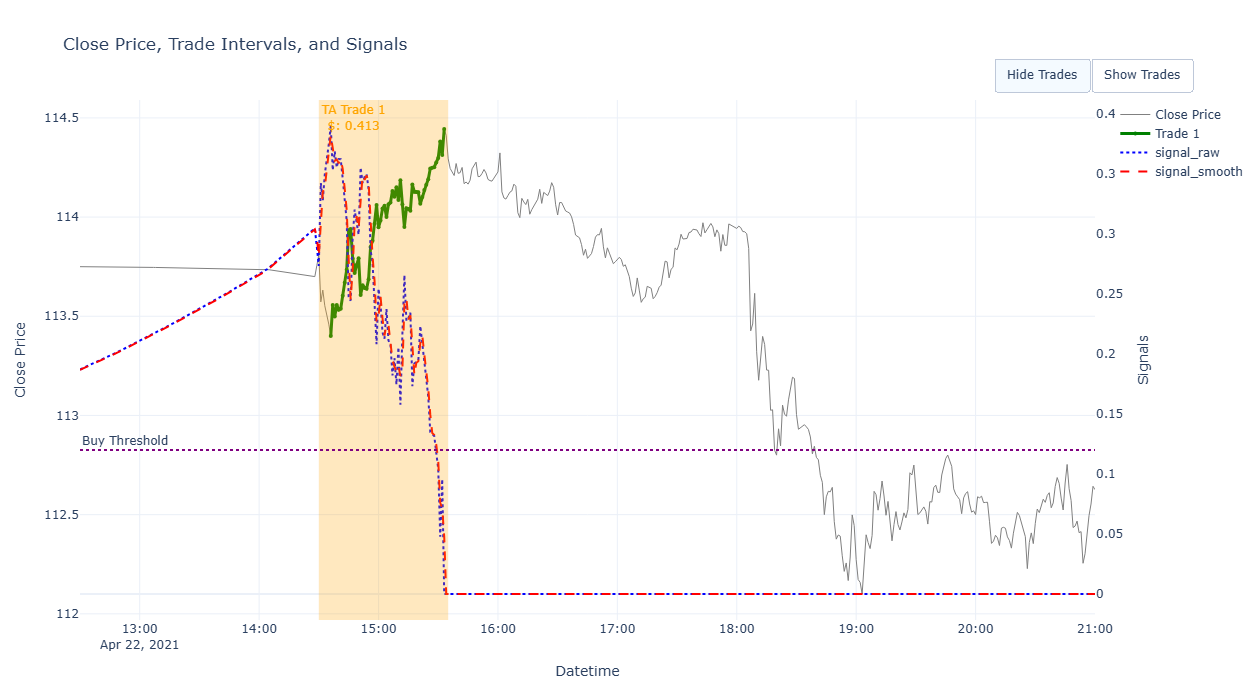


=== Performance for 2021-04-22 00:00:00 ===
Strategy Return ($): 0.413
Buy & Hold Return ($): -1.236
Trades Returns ($): [0.413]

=== Processing trading day 2021-04-23 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


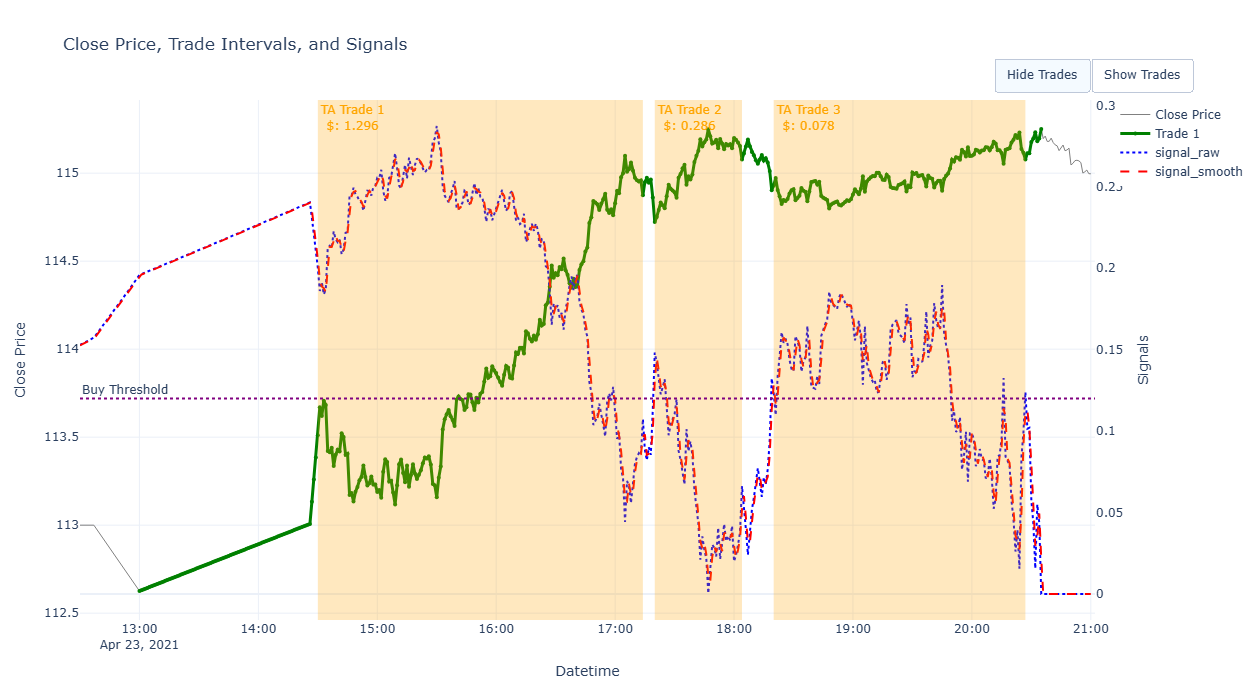


=== Performance for 2021-04-23 00:00:00 ===
Strategy Return ($): 1.66
Buy & Hold Return ($): 1.418
Trades Returns ($): [1.296, 0.286, 0.078]

=== Processing trading day 2021-04-26 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


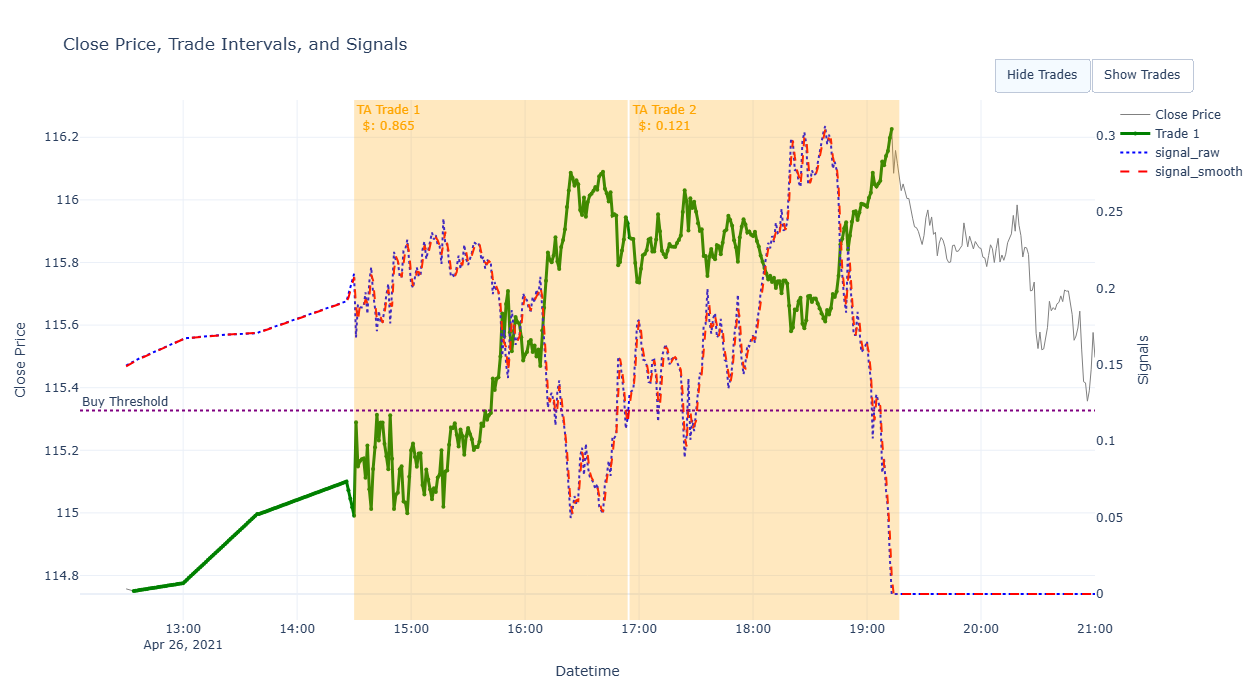


=== Performance for 2021-04-26 00:00:00 ===
Strategy Return ($): 0.986
Buy & Hold Return ($): 0.516
Trades Returns ($): [0.865, 0.121]

=== Processing trading day 2021-04-27 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2021-04-28 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



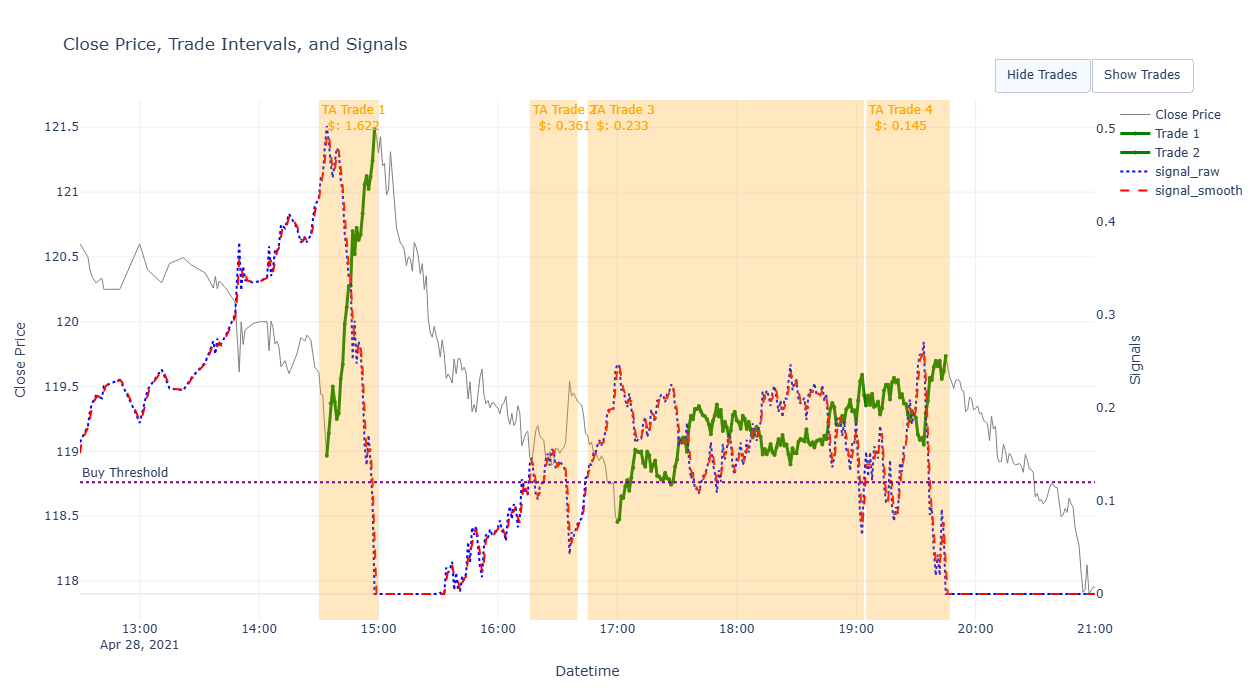


=== Performance for 2021-04-28 00:00:00 ===
Strategy Return ($): 2.362
Buy & Hold Return ($): -1.727
Trades Returns ($): [1.622, 0.361, 0.233, 0.145]

=== Processing trading day 2021-04-29 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


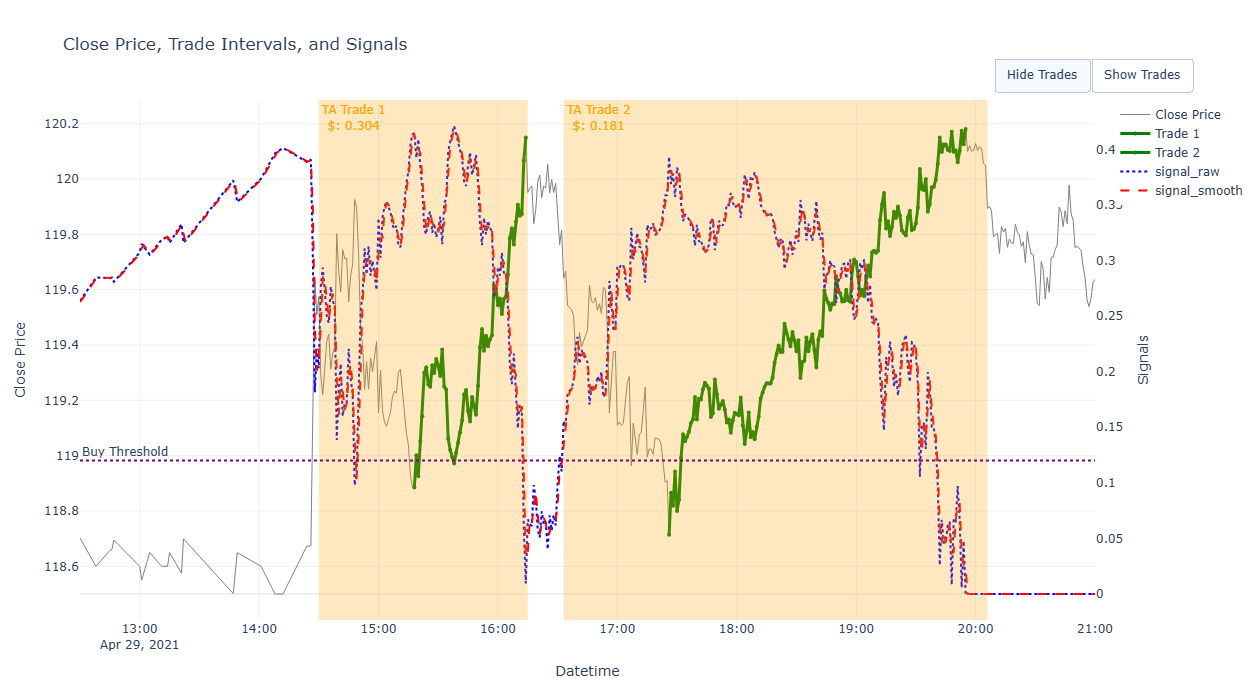


=== Performance for 2021-04-29 00:00:00 ===
Strategy Return ($): 0.485
Buy & Hold Return ($): -0.021
Trades Returns ($): [0.304, 0.181]

=== Processing trading day 2021-04-30 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


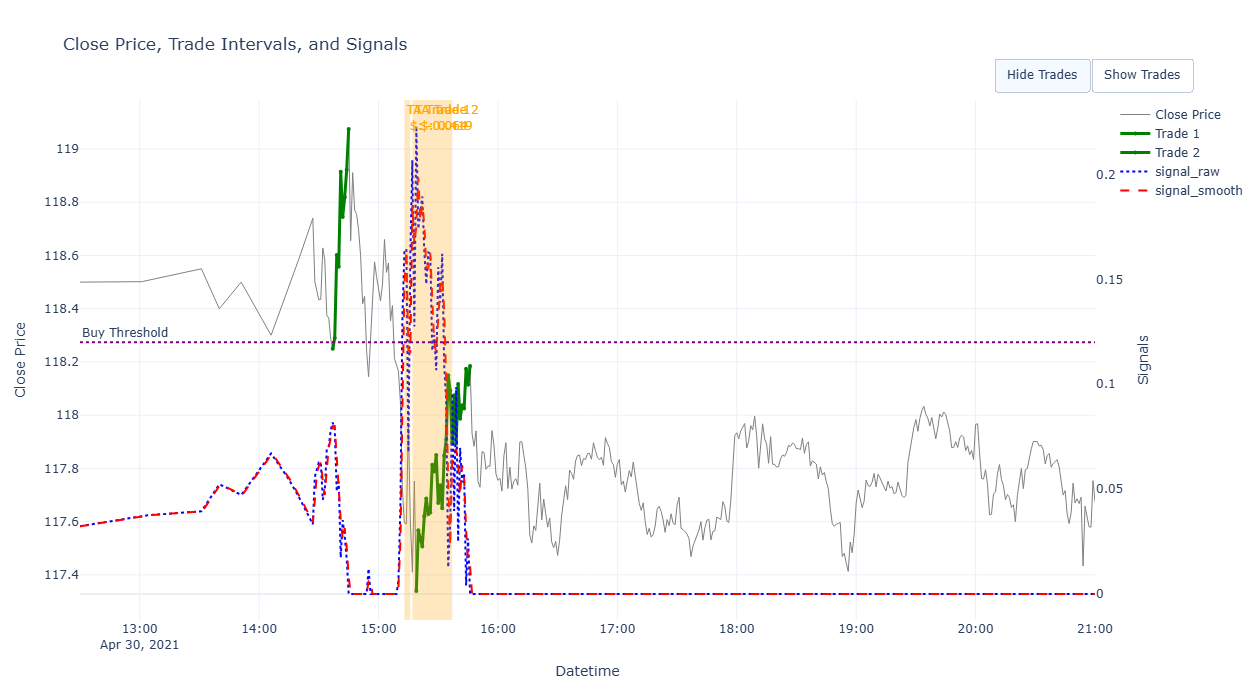


=== Performance for 2021-04-30 00:00:00 ===
Strategy Return ($): 0.355
Buy & Hold Return ($): -0.75
Trades Returns ($): [-0.064, 0.419]

=== Overall Summary (2021-04-01 → 2021-04-30) ===
Start date price: 2021-04-01 = 104.8850
  End date price:  2021-04-30 = 117.6397
One-time buy&hold gain: 12.755

{'Buy & Hold – each day ($)': 4.139,
 'Strategy Return ($)': 19.394,
 'Trades Returns ($)': '34 trades'}


open        high         low       close  \
2021-04-01 10:30:00  104.213551  104.213551  104.171495  104.171495   
2021-04-01 10:31:00  104.211916  104.211916  104.170280  104.170280   
2021-04-01 10:32:00  104.210280  104.210280  104.169065  104.169065   
2021-04-01 10:33:00  104.208645  104.208645  104.167850  104.167850   
2021-04-01 10:34:00  104.207009  104.207009  104.166636  104.166636   
...                         ...         ...         ...         ...   
2021-04-30 20:56:00  117.663000  117.663000  117.571200  117.625000   
2021-04-30 20:57:00  117.628000  117.628500  117.547000  117.580750   
2021-04-30 20:58:00  117.574000  117.620000  117.547000  117.579500   
2021-04-30 20:59:00  117.566500  117.754000  117.566500  117.754000   
2021-04-30 21:00:00  117.675000  117.675000  117.675000  117.675000   

                           volume         ask         bid   open_orig  \
2021-04-01 10:30:00  5.887477e+03  104.202748  104.140243  104.213551   
2021-04-01 10:31:00  5.871402e+03  104.201532  104.139028  104.211916   
2021-04-01 10:32:00  5.855327e+03  104.200317  104.137814  104.210280   
2021-04-01 10:33:00  5.839252e+03  104.199102  104.136599  104.208645   
2021-04-01 10:34:00  5.823178e+03  104.197886  104.135385  104.207009   
...                           ...         ...         ...         ...   
2021-04-30 20:56:00  4.410400e+05  117.660290  117.589710  117.663000   
2021-04-30 20:57:00  3.973800e+05  117.616025  117.545475  117.628000   
2021-04-30 20:58:00  5.037200e+05  117.614775  117.544225  117.574000   
2021-04-30 20:59:00  1.149680e+06  117.789325  117.718675  117.566500   
2021-04-30 21:00:00  1.911000e+05  117.710300  117.639700  117.675000   

                      high_orig    low_orig  close_orig   volume_orig  \
2021-04-01 10:30:00  104.213551  104.171495  104.171495  5.887477e+03   
2021-04-01 10:31:00  104.211916  104.170280  104.170280  5.871402e+03   
2021-04-01 10:32:00  104.210280  104.169065  104.169065  5.855327e+03   
2021-04-01 10:33:00  104.208645  104.167850  104.167850  5.839252e+03   
2021-04-01 10:34:00  104.207009  104.166636  104.166636  5.823178e+03   
...                         ...         ...         ...           ...   
2021-04-30 20:56:00  117.663000  117.571200  117.625000  4.410400e+05   
2021-04-30 20:57:00  117.628500  117.547000  117.580750  3.973800e+05   
2021-04-30 20:58:00  117.620000  117.547000  117.579500  5.037200e+05   
2021-04-30 20:59:00  117.754000  117.566500  117.754000  1.149680e+06   
2021-04-30 21:00:00  117.675000  117.675000  117.675000  1.911000e+05   

                       ask_orig    bid_orig  signal_raw  signal_smooth  \
2021-04-01 10:30:00  104.202748  104.140243    0.097737       0.097737   
2021-04-01 10:31:00  104.201532  104.139028    0.098209       0.097973   
2021-04-01 10:32:00  104.200317  104.137814    0.098683       0.098446   
2021-04-01 10:33:00  104.199102  104.136599    0.099158       0.098921   
2021-04-01 10:34:00  104.197886  104.135385    0.099637       0.099398   
...                         ...         ...         ...            ...   
2021-04-30 20:56:00  117.660290  117.589710    0.000000       0.000000   
2021-04-30 20:57:00  117.616025  117.545475    0.000000       0.000000   
2021-04-30 20:58:00  117.614775  117.544225    0.000000       0.000000   
2021-04-30 20:59:00  117.789325  117.718675    0.000000       0.000000   
2021-04-30 21:00:00  117.710300  117.639700    0.000000       0.000000   

                     signal_action  Position   Cash  NetValue    Action  \
2021-04-01 10:30:00              0         0  0.000     0.000  No trade   
2021-04-01 10:31:00              0         0  0.000     0.000  No trade   
2021-04-01 10:32:00              0         0  0.000     0.000  No trade   
2021-04-01 10:33:00              0         0  0.000     0.000  No trade   
2021-04-01 10:34:00              0         0  0.000     0.000  No trade   
...                            ...       ...    ...       ...       ...   
2021-0

In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_man, 
                        max_down_prop=params.max_down_prop_man, 
                        gain_tightening_factor=params.gain_tightening_factor_man,
                        smooth_win_sig=params.smooth_win_sig_man, 
                        pre_entry_decay=params.pre_entry_decay_man, 
                        buy_threshold=params.buy_threshold_man, 
                        trailing_stop_thresh=params.trailing_stop_thresh_man,
                        merging_retracement_thr=params.merging_retracement_thr_man, 
                        merging_time_gap_thr=params.merging_time_gap_thr_man,
                        date_to_check=params.date_to_check
                        )

df_fin


In [7]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal_smooth & signal_raw on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal_smooth"],
            color="tab:blue", lw=1.5, label="signal_smooth"
        )
        ax1.plot(
            df_day.index, df_day["signal_raw"],
            color="tab:red",  lw=1.5, label="signal_raw"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
